In [1]:
from qiskit import *
import numpy as np
from qiskit import IBMQ

token='a2afa69f70955de3c84068e58c44bd81e01740c07ff40db7e9ab824c0da8b9412da7a86e9c453f7f97ecc35fc9f09948ce053cbd9e8213b98feadba15dcc467f'
#IBMQ.enable_account(token)
IBMQ.save_account(token,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl',group='ornl',project='csc517')
backend = provider.get_backend('ibm_sherbrooke')
backend_config = backend.configuration()

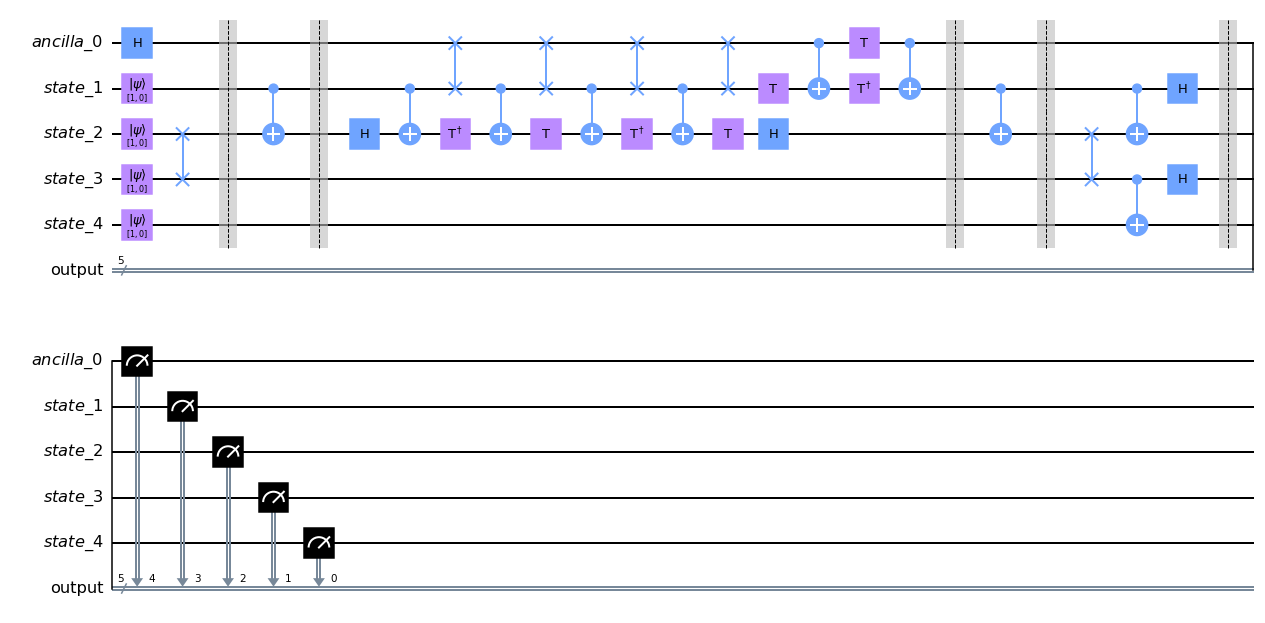

In [2]:
ancilla = QuantumRegister(1, 'ancilla_0')
A = QuantumRegister(1,'state_1')
B = QuantumRegister(1,'state_2')
C = QuantumRegister(1,'state_3')
D = QuantumRegister(1,'state_4')
Meas = ClassicalRegister(5,'output')

circuit = QuantumCircuit(ancilla, A, B, C, D, Meas)

angle = 0*np.pi

circuit.initialize([np.cos(0*angle/2),np.sin(0*angle/2)],0+1)
circuit.initialize([np.cos(1*angle/2),np.sin(1*angle/2)],1+1)
circuit.initialize([np.cos(2*angle/2),np.sin(2*angle/2)],2+1)
circuit.initialize([np.cos(3*angle/2),np.sin(3*angle/2)],3+1)

circuit.h(0)

#circuit.cswap(0,1,3) This is getting replaced by:

circuit.swap(2,3) #an initial swap will minimize future swaps during the Toffoli decomposition
circuit.barrier()
circuit.cx(1,2)
circuit.barrier()
### Decomposed Toffoli, using swaps instead of CNOT gates operating on separated qubits
circuit.h(2)
circuit.cx(1,2)
circuit.tdg(2)
circuit.swap(0,1)
circuit.cx(1,2)
circuit.swap(0,1)
circuit.t(2)
circuit.cx(1,2)
circuit.tdg(2)
circuit.swap(0,1)
circuit.cx(1,2)
circuit.swap(0,1)
circuit.t(1)
circuit.t(2)
circuit.h(2)
circuit.cx(0,1)
circuit.t(0)
circuit.tdg(1)
circuit.cx(0,1)
###
circuit.barrier()
circuit.cx(1,2)

#correcting swap and final gates needed for Bell measurement
circuit.barrier()
circuit.swap(2,3)
circuit.cx(1,2)
circuit.cx(3,4)
circuit.h(1)
circuit.h(3)

circuit.barrier()

circuit.measure(0,4-0)
circuit.measure(1,4-1)
circuit.measure(2,4-2)
circuit.measure(3,4-3)
circuit.measure(4,4-4)
    

circuit.draw(output='mpl')

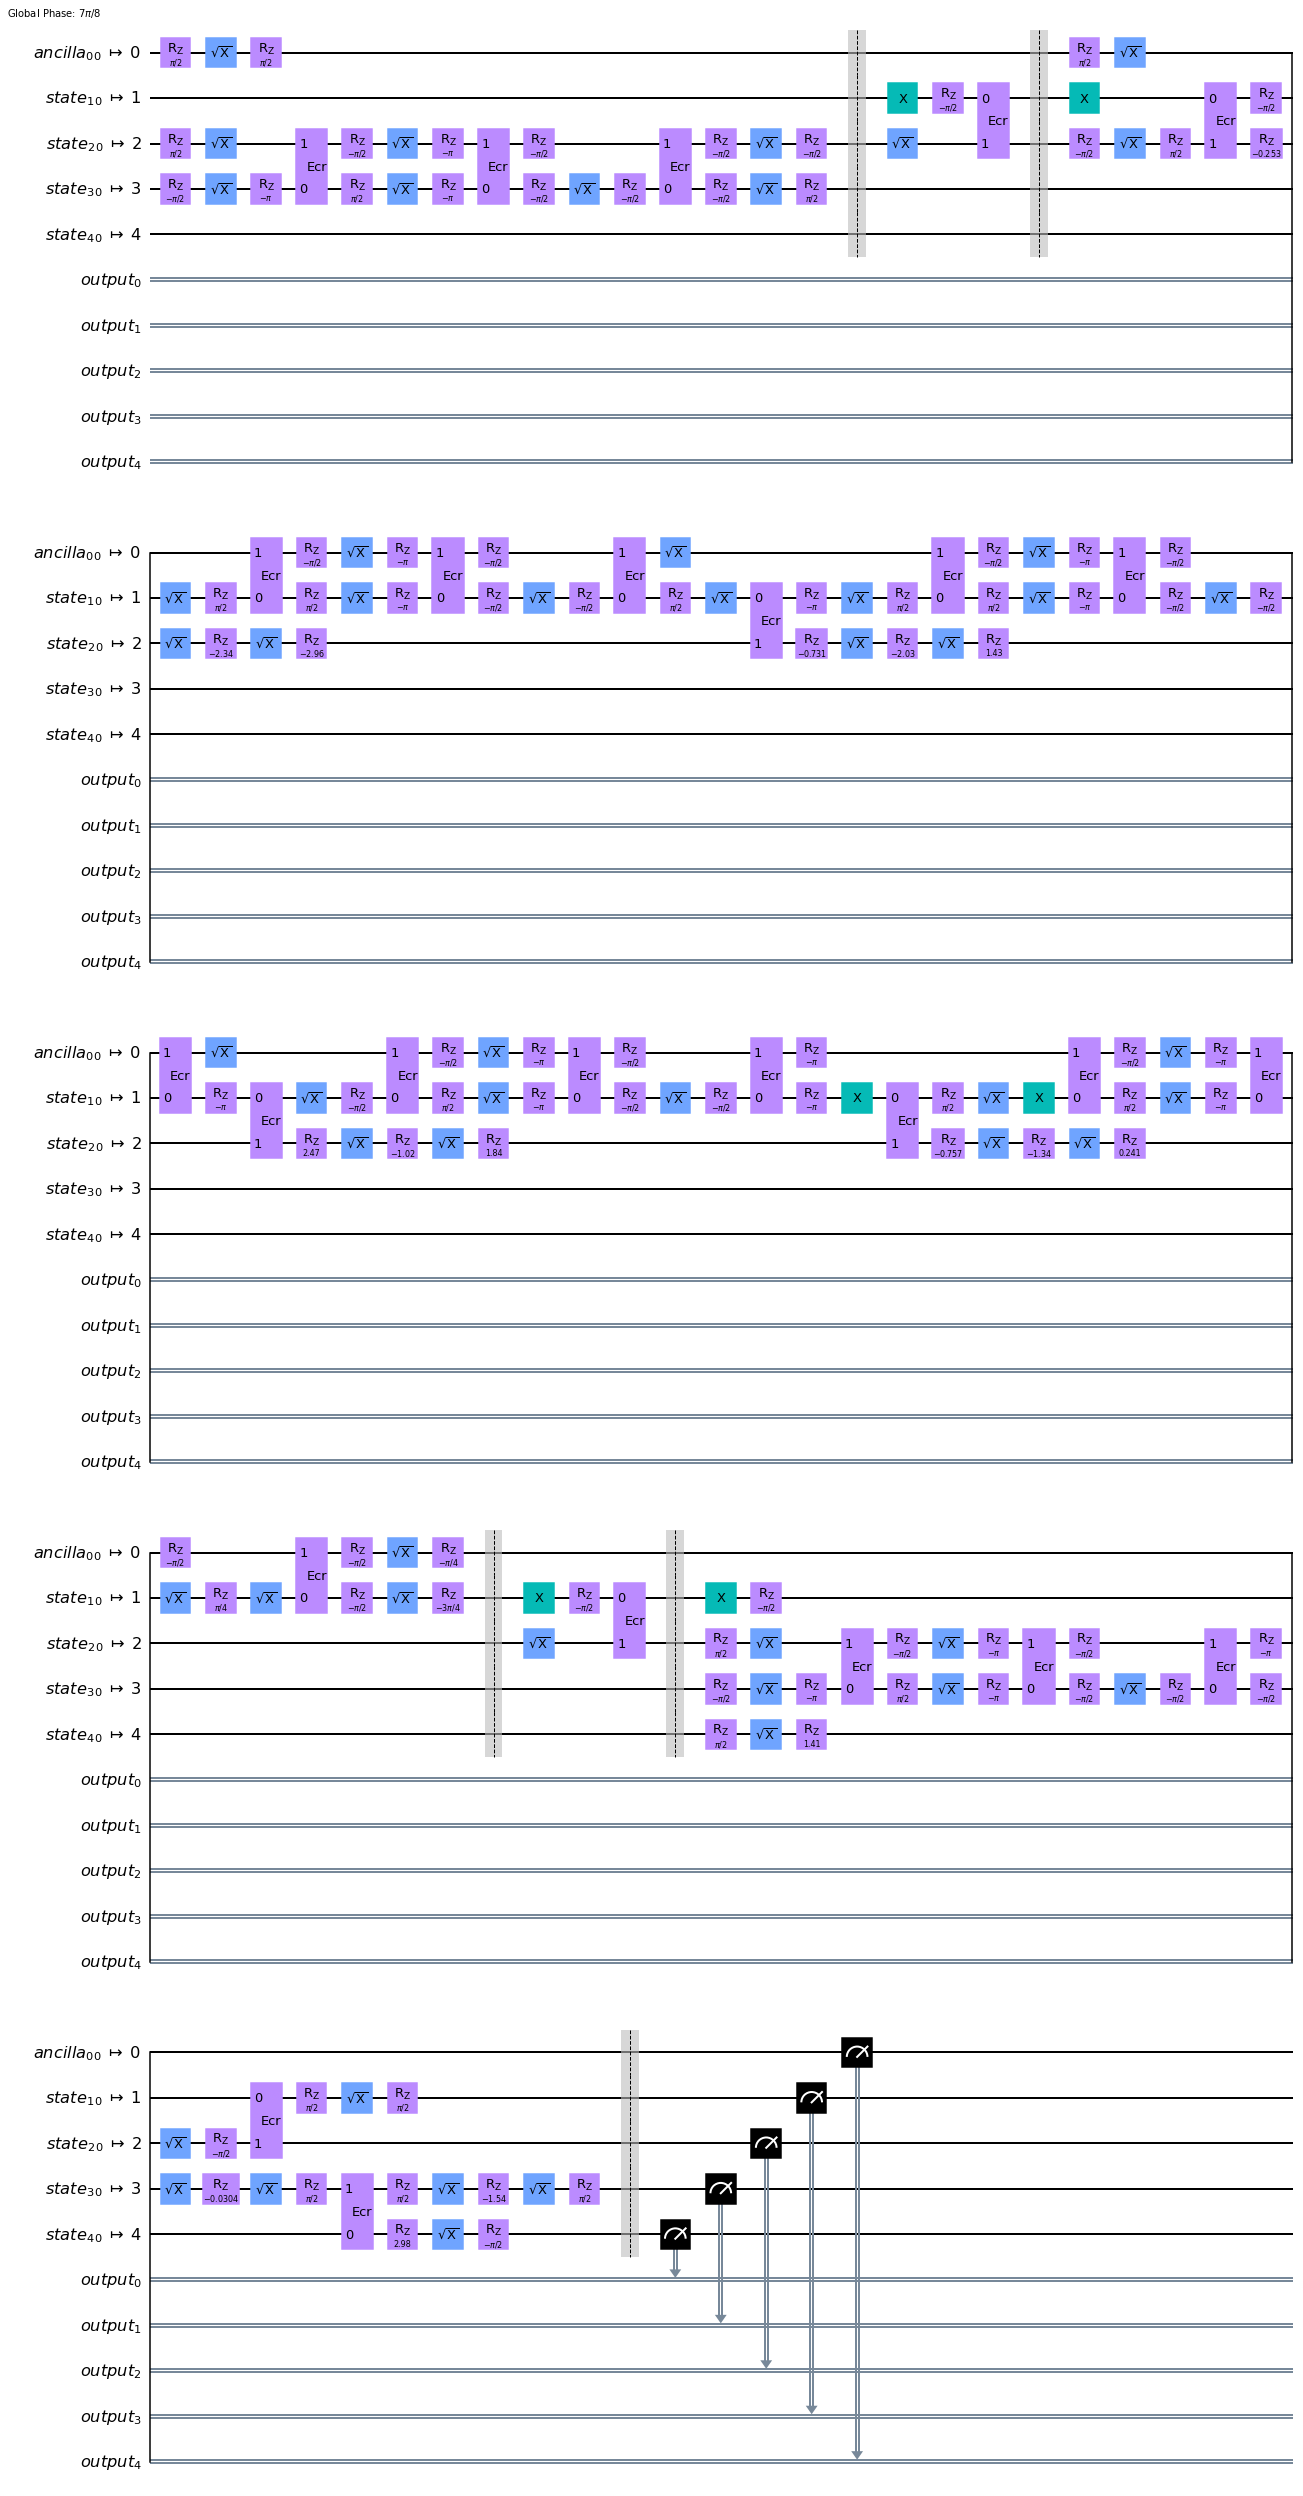

In [3]:
final = transpile(circuit, backend, optimization_level = 3)
final.draw('mpl',cregbundle=False,idle_wires=False)
# 28 ECRs on sherbrooke, transpile 1
# 26 ECRs on sherbrooke, transpile 3
# 31 CNOTs on hanoi
# 40 CNOTs on guadalupe

In [15]:
shots = 1000
job = backend.run(final,shots=shots)

from qiskit.tools.monitor import job_monitor
#job_monitor(job)

In [ ]:
result = job.result(timeout=120)
counts = result.get_counts(circuit)
print(counts)

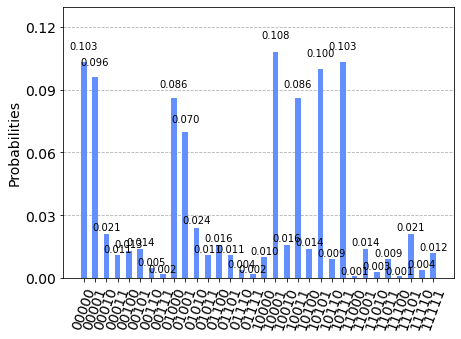

In [174]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [176]:


r12 = 1-4*(counts.get('01100',0)+counts.get('01101',0)+counts.get('01110',0)+counts.get('01111',0))/shots
print(f"r_12 = {r12}")
r23 = 1-4*(counts.get('11100',0)+counts.get('11101',0)+counts.get('11110',0)+counts.get('11111',0))/shots
print(f"r_23 = {r23}")
r34 = 1-4*(counts.get('00011',0)+counts.get('00111',0)+counts.get('01011',0)+counts.get('01111',0))/shots
print(f"r_34 = {r34}")
r14 = 1-4*(counts.get('10011',0)+counts.get('10111',0)+counts.get('11011',0)+counts.get('11111',0))/shots
print(f"r_14 = {r14}")

inequality = r12 + r23 + r34 - r14

print(f"r_12 + r_23 + r_34 - r_14 = {inequality}")

print(f"\nraw:\n{angle/np.pi},{r12},{r23},{r34},{r14},{inequality}")



r_12 = 0.736
r_23 = 0.696
r_34 = 0.792
r_14 = -0.6799999999999999
r_12 + r_23 + r_34 - r_14 = 2.904

raw:
0.26,0.736,0.696,0.792,-0.6799999999999999,2.904
